## Kaggel比赛之房价预测：
> 赛题链接： [房价预测](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)
>
> 思路分享(有以下问题要解决）：
>> 1. 数据明确 -> 查看数据集和数据的描述，理解意思 -> 解决问题的思路
>> 2. 数据明确之后，要想这是个什么问题？ （回归做预测）
>> 3. 这时候要想起哪些算法可以做回归（线性回归、决策树、XGB、SVM等）
>> 4. 数据中是否含有字符串或者缺失值？ 如何把它们变成数值型的？
>> 5. 数据特征工程的思路， 数据的EDA(pandas_profling)探索性数据分析、特征选择、再就是数据特征组合或者特征分割等
>> 6. 然后就是算法的选择
>
> 思路展开： 数据探索， 做一点点的修改 -> 数据清洗（空值的填充） --> 数据预处理（数据归一化，标准化） --> 模型的构建 --> 训练预测 -- 保存提交
>
><br>
>PS: 这是房价预测的初级版本，主要是学习对数据应该怎么查看和处理

###  第一部分： 导入数据与查看
> * 数据的导入,查看整体数据以及明确内容： pandas 的read_csv

In [1]:
"""导入用到的包"""
import numpy as np
import pandas as pd
import pandas_profiling as ppf    #  探索性数据分析工具(EDA)
import matplotlib.pyplot as plt
import seaborn as sns         #  统计数据可视化

from sklearn.preprocessing import LabelEncoder, StandardScaler



import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')


In [2]:
"""导入数据"""
train_set = pd.read_csv("dataset/train.csv")
test_set = pd.read_csv("dataset/test.csv")

In [3]:
"""查看数据"""
train_set.head(5)   # nan 就是空值
#print(train_set.shape)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [7]:
"""用探测性分析工具产生数据报表"""
ppf.ProfileReport(train_set)
## 皮尔逊系数： 单变量的相关性  特征与特征之间相关性系数，特征越高，就越接近1
## spear曼系数： 多变量的相关性

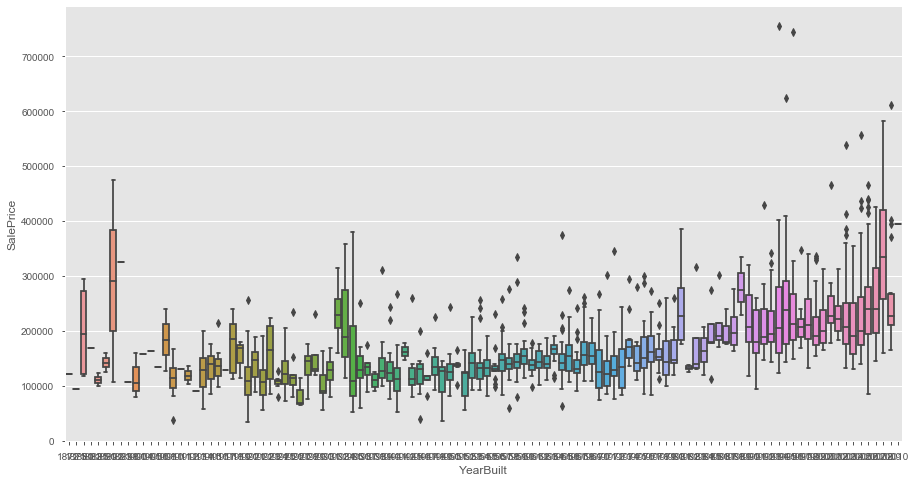

In [13]:
"""查看异常值  箱线图"""
# 箱型图是看异常值的，离群点
plt.figure(figsize=(15, 8))
sns.boxplot(train_set.YearBuilt, train_set.SalePrice)  # 建造年份与预测价格的关系

'图中可以看到，到了后面的那些点太散了，所以考虑删掉'

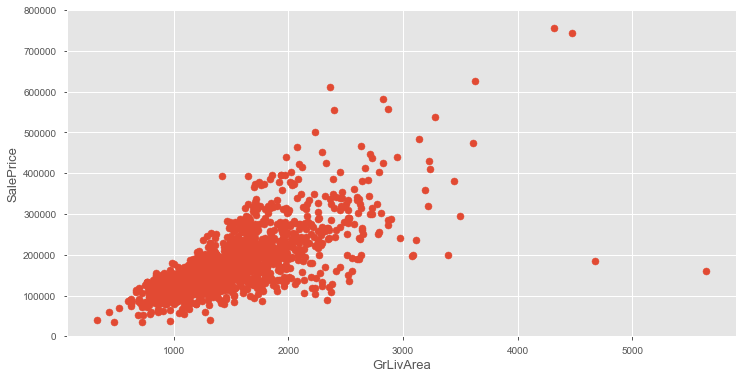

In [16]:
"""查看线性关系 - 散点图"""
plt.figure(figsize=(12, 6))
plt.scatter(x=train_set.GrLivArea, y=train_set.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0, 800000)

"""图中可以看到，到了后面的那些点太散了，所以考虑删掉"""

In [4]:
"""按照条件删掉那些异常或者散的样本"""
# pandas 里面的条件索引
train_set.drop(train_set[(train_set['GrLivArea']>4000)&(train_set['SalePrice']<300000)].index, inplace=True) 

### 第二部分： 数据清洗与处理 
#### 理论知识部分：
> * 数据清洗： 对数据进行重新审查和校验的过程，目的在于删除重复信息，纠正存在的错误，并提供数据一致性
>> 数据清洗的难点： 数据清洗一般针对具体应用， 因而难以归纳统一的方法和步骤，但是根据数据不同可以给出相应的数据清理方法：
>>>1. 解决缺失值： 平均值、最大值、最小值或更为复杂的概率估计代替缺失值
>>>2. 去重： 相等的记录合并为一条记录（即合并/清除）
>>>3. 解决错误值：用统计分析方法识别可能的错误值或异常值，如偏差分析、识别不遵守分布或回归方程的值，也可以用简单规则库（常识性规则，业务规则等）检查数据值，或使用不同属性间的约束，外部的数据来检测和清理数据
>>>4. 解决数据的不一致性： 比如数据是类别型（LabelEncoder或者OneHotEncoder）或者次序型
>>
>> 数据清洗的八大场景：
>>>1. 删除多列
>>>2. 更改数据类型
>>>3. 将分类变量转换为数字变量
>>>4. 检查缺失数据(一般是NAN)
>>>5. 删除列中的字符串
>>>6. 删除列中的空格
>>>7. 用字符串连接两列（带条件）
>>>8. 转换时间戳（从字符串到日期时间格式）
>>
>> 数据处理方法：
>>> 1. 对数变换
>>> 2. 标准缩放
>>> 3. 转换数据类型
>>> 4. 独热编码
>>> 5. 标签编码

In [5]:
# 先把train和test放在一块处理
full = pd.concat([train_set, test_set], ignore_index=True)

# 删掉ID列
full.drop("Id", axis=1, inplace=True)
full.head()

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType BsmtCond  \
0       856       854          0   NaN             3     1Fam       TA   
1      1262         0          0   NaN             3     1Fam       TA   
2       920       866          0   NaN             3     1Fam       TA   
3       961       756          0   NaN             3     1Fam       Gd   
4      1145      1053          0   NaN             4     1Fam       TA   

  BsmtExposure  BsmtFinSF1  BsmtFinSF2  ... SaleType ScreenPorch  Street  \
0           No       706.0         0.0  ...       WD           0    Pave   
1           Gd       978.0         0.0  ...       WD           0    Pave   
2           Mn       486.0         0.0  ...       WD           0    Pave   
3           No       216.0         0.0  ...       WD           0    Pave   
4           Av       655.0         0.0  ...       WD           0    Pave   

   TotRmsAbvGrd TotalBsmtSF  Utilities WoodDeckSF YearBuilt YearRemodAdd  \
0             8       856.0     AllPub          0      2003         2003   
1             6      1262.0     AllPub        298      1976         1976   
2             6       920.0     AllPub          0      2001         2002   
3             7       756.0     AllPub          0      1915         1970   
4             9      1145.0     AllPub        192      2000         2000   

  YrSold  
0   2008  
1   2007  
2   2008  
3   2006  
4   2008  

[5 rows x 80 columns]

In [6]:
full.info()   # 查看数据的一个信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 80 columns):
1stFlrSF         2917 non-null int64
2ndFlrSF         2917 non-null int64
3SsnPorch        2917 non-null int64
Alley            198 non-null object
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null object
BsmtCond         2835 non-null object
BsmtExposure     2835 non-null object
BsmtFinSF1       2916 non-null float64
BsmtFinSF2       2916 non-null float64
BsmtFinType1     2838 non-null object
BsmtFinType2     2837 non-null object
BsmtFullBath     2915 non-null float64
BsmtHalfBath     2915 non-null float64
BsmtQual         2836 non-null object
BsmtUnfSF        2916 non-null float64
CentralAir       2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
Electrical       2916 non-null object
EnclosedPorch    2917 non-null int64
ExterCond        2917 non-null object
ExterQual        2917 non-null object
Exterior1st      291

####  数据清洗 - 空值的填充与删除
> * 空值填充
> * 空值的删除
> * 空值不处理
>
PS: 空值的填充要分对象 字符或者数字等

In [7]:
"""查看缺失值， 并且缺失的个数要从高低排序"""
miss = full.isnull().sum()   # 统计每一列缺失值个数
miss[miss>0].sort_values(ascending=False)   # 缺失值由低到高排序

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

In [8]:
"""对字符类型的数据进行填充"""
# 筛选出字符类型的列， 并且填充None
# for col in full.columns:
#     if(full[col].dtype=='object'):
#         full[col].fillna('None', inplace=True)
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None",inplace=True)

In [9]:
"""对数值类型的进行填充"""
# 筛选出数值类型的列
# for i in full.columns:
#     if(full[i].dtype == 'float64' and i != 'SalePrice'):   # 浮点数用0填充
#         full[i].fillna(0, inplace=True)
#     if(full[i].dtype == 'int64'):  # 用众数填充
#         full[i].fillna(full[i].mode()[0], inplace=True)

cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

In [10]:
"""对lotfrontage的空值进行填充（用这一列的均值）"""
full['LotFrontage'].fillna(np.mean(full["LotFrontage"]), inplace=True)

In [12]:
"""众数填充一些列"""
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

In [13]:
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

###  数据预处理 
> 将一些数字特征转换成类别特征，最好用LabelEncoder和get_dummies来实现这些功能
>
> * 非数值型数据通过LabelEncoder和OneHotEncoder编码转换成数值型
> * 数据的归一化，标准化处理

In [14]:
full['MSZoning'].mode()[0]

'RL'

In [15]:
full.MSZoning

0            RL
1            RL
2            RL
3            RL
4            RL
5            RL
6            RL
7            RL
8            RM
9            RL
10           RL
11           RL
12           RL
13           RL
14           RL
15           RM
16           RL
17           RL
18           RL
19           RL
20           RL
21           RM
22           RL
23           RM
24           RL
25           RL
26           RL
27           RL
28           RL
29           RM
         ...   
2887         RM
2888         RM
2889    C (all)
2890    C (all)
2891    C (all)
2892         RM
2893         RM
2894         RL
2895         RL
2896         RL
2897         RL
2898         RL
2899         RL
2900         RL
2901         RL
2902         RL
2903         RM
2904         RM
2905         RL
2906         RL
2907         RM
2908         RM
2909         RL
2910         RM
2911         RM
2912         RM
2913         RM
2914         RL
2915         RL
2916         RL
Name: MSZoning, Length: 

In [16]:
for col in cols2:
    full[col] = full[col].astype(str)  ## astype来进行数据类型转换

In [15]:
"""下面进行字符型向数值型数据转换 -- LabelEncoder"""
lab = LabelEncoder()

full['Alley'] = lab.fit_transform(full.Alley)
full["PoolQC"] = lab.fit_transform(full.PoolQC)
full["MiscFeature"] = lab.fit_transform(full.MiscFeature)
full["Fence"] = lab.fit_transform(full.Fence)
full["FireplaceQu"] = lab.fit_transform(full.FireplaceQu)
full["GarageQual"] = lab.fit_transform(full.GarageQual)
full["GarageCond"] = lab.fit_transform(full.GarageCond)
full["GarageFinish"] = lab.fit_transform(full.GarageFinish)
full["GarageYrBlt"] = full["GarageYrBlt"].astype(str)
full["GarageYrBlt"] = lab.fit_transform(full.GarageYrBlt)
full["GarageType"] = lab.fit_transform(full.GarageType)
full["BsmtExposure"] = lab.fit_transform(full.BsmtExposure)
full["BsmtCond"] = lab.fit_transform(full.BsmtCond)
full["BsmtQual"] = lab.fit_transform(full.BsmtQual)
full["BsmtFinType2"] = lab.fit_transform(full.BsmtFinType2)
full["BsmtFinType1"] = lab.fit_transform(full.BsmtFinType1)
full["MasVnrType"] = lab.fit_transform(full.MasVnrType)
full["BsmtFinType1"] = lab.fit_transform(full.BsmtFinType1)

In [16]:
full.head(5)

1stFlrSF  2ndFlrSF  3SsnPorch  Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0      1             3     1Fam         4   
1      1262         0          0      1             3     1Fam         4   
2       920       866          0      1             3     1Fam         4   
3       961       756          0      1             3     1Fam         1   
4      1145      1053          0      1             4     1Fam         4   

   BsmtExposure  BsmtFinSF1  BsmtFinSF2  ...  SaleType  ScreenPorch  Street  \
0             3       706.0         0.0  ...        WD            0    Pave   
1             1       978.0         0.0  ...        WD            0    Pave   
2             2       486.0         0.0  ...        WD            0    Pave   
3             3       216.0         0.0  ...        WD            0    Pave   
4             0       655.0         0.0  ...        WD            0    Pave   

   TotRmsAbvGrd  TotalBsmtSF  Utilities WoodDeckSF YearBuilt YearRemodAdd  \
0             8        856.0     AllPub          0      2003         2003   
1             6       1262.0     AllPub        298      1976         1976   
2             6        920.0     AllPub          0      2001         2002   
3             7        756.0     AllPub          0      1915         1970   
4             9       1145.0     AllPub        192      2000         2000   

  YrSold  
0   2008  
1   2007  
2   2008  
3   2006  
4   2008  

[5 rows x 80 columns]

In [17]:
full["MSZoning"] = lab.fit_transform(full.MSZoning)
full["BsmtFullBath"] = lab.fit_transform(full.BsmtFullBath)
full["BsmtHalfBath"] = lab.fit_transform(full.BsmtHalfBath)
full["Utilities"] = lab.fit_transform(full.Utilities)
full["Functional"] = lab.fit_transform(full.Functional)
full["Electrical"] = lab.fit_transform(full.Electrical)
full["KitchenQual"] = lab.fit_transform(full.KitchenQual)
full["SaleType"] = lab.fit_transform(full.SaleType)
full["Exterior1st"] = lab.fit_transform(full.Exterior1st)
full["Exterior2nd"] = lab.fit_transform(full.Exterior2nd)

In [18]:
full.head()

1stFlrSF  2ndFlrSF  3SsnPorch  Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0      1             3     1Fam         4   
1      1262         0          0      1             3     1Fam         4   
2       920       866          0      1             3     1Fam         4   
3       961       756          0      1             3     1Fam         1   
4      1145      1053          0      1             4     1Fam         4   

   BsmtExposure  BsmtFinSF1  BsmtFinSF2  ...  SaleType  ScreenPorch  Street  \
0             3       706.0         0.0  ...         8            0    Pave   
1             1       978.0         0.0  ...         8            0    Pave   
2             2       486.0         0.0  ...         8            0    Pave   
3             3       216.0         0.0  ...         8            0    Pave   
4             0       655.0         0.0  ...         8            0    Pave   

   TotRmsAbvGrd  TotalBsmtSF  Utilities WoodDeckSF YearBuilt YearRemodAdd  \
0             8        856.0          0          0      2003         2003   
1             6       1262.0          0        298      1976         1976   
2             6        920.0          0          0      2001         2002   
3             7        756.0          0          0      1915         1970   
4             9       1145.0          0        192      2000         2000   

   YrSold  
0    2008  
1    2007  
2    2008  
3    2006  
4    2008  

[5 rows x 80 columns]

In [19]:
full.drop('SalePrice', axis=1, inplace=True)

In [20]:
"""下面进行独热编码"""
full2 = pd.get_dummies(full)


In [21]:
full2.shape

(2917, 182)

In [22]:
"""归一化标准化处理"""

# 划分数据集
n_train = train_set.shape[0]
X = full2[:n_train]
y = train_set.SalePrice    #  取出训练集的特征与标签

test_x = full2[n_train:]  # 取出测试集

In [23]:
std = StandardScaler()
X_scaled = std.fit_transform(X)
# y = np.log(y)      # 训练集的一个数据分布


### 模型的构建与测试

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
model = LinearRegression()
model.fit(X_scaled, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
predict = model.predict(test_x)

In [28]:
"""下面就可以提交初步结果"""
result = pd.DataFrame({'Id':test_set.Id, 'SalePrice':predict})
result.to_csv("submission.csv", index=False)

## 总结：
> 通过这个笔记本，我们完成了一个基本的房价预测的baseline， 但是这只是最简单的处理，精度并不是很高，下面通过这个baseline看看学到了哪些知识：
>> * 数据的处理流程， 从导入数据，到数据的查看，这里学习到了EDA，pandas_profile这个东西比较好用
>> * OneHotEncoder是针对特征的， LabelEncoder是针对标签的一般
>> * 数据的清洗部分， 主要是缺失值的处理和填充方式
>> * 数据类型的转换， 用LabelEncoder和OneHotEncoder等
>> * 建立了最简单的模型进行的测试
>
> 需要改进的地方： 并没有做特征工程部分，也就是特征的选取和组合等都没有做，并且选择的模型也不太好，还需进一步提高，所以下面，在提高这个baseline之前，先看一下特征工程的相关知识，究竟怎么做特征工程。